In [49]:
# import  pandas, numpy, matplotlib, seaborn and os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [50]:
import warnings


warnings.filterwarnings('ignore')

In [51]:
keys_list = [
    'CPU time spent (ms)', 
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'Peak Map Physical memory (bytes)',
	'Peak Map Virtual memory (bytes)',
	'Peak Reduce Physical memory (bytes)',
	'Peak Reduce Virtual memory (bytes)'
]

In [52]:
# For each file we have to read the data about 2 jobs
# 'Running job: job_1718873180387_0052' this line shows the start point of a job

# For each job we have to read the following lines to get the performance data and store them in a dataframe regarding mapper and reducer of the 2 jobs

# The first job is 'LetterCount' and the second job is 'LetterFrequency'

def get_performance_data_job(data):
    # job_number = 1 for 'LetterCount' and 2 for 'LetterFrequency'
    # key -> Running job
     
    counter = 0
    
    data_1_job = []
    data_2_job = []
    

    # get the index of the second job
    for i in range(len(data)):
        if 'Running job:' in data[i]:
            counter += 1
            if counter == 2:
                data_1_job = data[:i] # take the data until the second job start key
                data_2_job = data[i:] # take the data from the second job start key
                break

    # create a dictionary to store the performance data of the two jobs
    jobs = {
        'LetterCount': data_1_job,
        'LetterFrequency': data_2_job
    }
    
    return jobs

def get_performance_data(file):
    with open(file) as f:
        lines = f.readlines()
    
    # Separete the performance data of the two jobs
    jobs = get_performance_data_job(lines)  
        
    # each value of jobs is a list of strings that contains the performance data of a job (mapper and reducer)
    
    performance_data = {
        'LetterCount': {},
        'LetterFrequency': {}
    }
    
    # For each job
    for job_name, job in jobs.items():
        
        # get the start index of the performance data
            start_index = 0
            for j in range(len(job)):
                if 'Job Counters' in job[j]:
                    start_index = j
                    break
                
            # get the end index of the performance dataù
            end_index = 0
            for j in range(len(job)):
                if 'Shuffle Errors' in job[j]:
                    end_index = j
                    break
            
            # get the performance data
            data = job[start_index:end_index]
            
            # iterate over data to get values of keys_list
            
            # Example of data:
            
		    #Total time spent by all map tasks (ms)=25302
		    #Total time spent by all reduce tasks (ms)=2543
      
            #Peak Map Physical memory (bytes)=277716992
		    #Peak Map Virtual memory (bytes)=1868095488
		    #Peak Reduce Physical memory (bytes)=170889216
		    #Peak Reduce Virtual memory (bytes)=1872019456
            
      
            for line in data:
                for key in keys_list:
                    if key in line.strip():
                        value = int(line.split('=')[1])
                        performance_data[job_name][key] = value
                        
            
            # from the path of the file (i.e. .\resources\output\performance_analysis\dante\1_reducer\combiner\dante_normalized.txt) get the name of the opera or the author and the type (combiner or inmappercombiner)
            
            # get the file name from the full path
            file_name = os.path.basename(file)

            # extract the name of the opera or the author from the file name
            opera = file_name.split('.') # -> ['dante_normalized', 'txt']
            
            opera = opera[0] # -> 'dante_normalized'
            
            # the opera can have a name with more than one word (i.e. moby_dick)
            # if _normalized is present remove it
            opera = opera.split('_normalized')[0]

            # extract the type (combiner or inmappercombiner) from the path
            
            path_parts = file.split(os.sep)
            
            type_name = path_parts[-2]
            
            # numer of reducers
            # get the name of the folder from path_parts[-3]
            # get the number of reducers from the folder name
            # Example of folder name: 1_reducer
            
            folder_name = path_parts[-3]
            num_reducers = int(folder_name.split('_')[0])
            
            
            # store the data in the dictionary
            performance_data[job_name]['Opera'] = opera
            
            performance_data[job_name]['Type'] = type_name
            
            if job_name == 'LetterFrequency':

                performance_data[job_name]['NumReducers'] = num_reducers
            else:
                performance_data[job_name]['NumReducers'] = 1
                        
            
                            
    return performance_data
                                    

In [53]:
# define a funnction to create the proper file path name for the performance data

def get_dir_path(opera):
    # Get the current working directory
    current_dir = os.getcwd()
    
    # Navigate to the parent directory
    parent_dir = os.path.join(current_dir, os.pardir)
    
    # Join the different parts of the path in a platform-independent manner
    return os.path.join(parent_dir, 'resources', 'output', 'performance_analysis', opera)

In [54]:
# define a function to create a dataframe from the performance data
def create_performance_df(data):
    # Trasformare il dizionario in un DataFrame
    df = pd.DataFrame(data).T.reset_index()

    # Rinominare la colonna 'index' in 'Job'
    df.rename(columns={'index': 'Job'}, inplace=True)

    # Visualizzare il DataFrame
    return df

In [55]:
def process_file(file_path, dataframe):
    
    print(f"Processing file: {file_path}")
    data = get_performance_data(file_path)
    
    # if dataframe is empty, create it
    if dataframe.empty:
        df = create_performance_df(data)
    else:
        df = pd.concat([dataframe, create_performance_df(data)], ignore_index=True)
    
    return df
    
    
    

def iterate_and_process(root_folder):
    
    dataframe = pd.DataFrame()
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if '_normalized.txt' not in file:
                continue
            file_path = os.path.join(root, file)
            
            dataframe = process_file(file_path, dataframe)
            
    return dataframe
            

# Dante 
## Divina Commedia

In [56]:
# Percorso della cartella principale
root_folder = get_dir_path('divina_commedia')

# Chiamata alla funzione di iterazione
dante_df = iterate_and_process(root_folder)
dante_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\divina_commedia\1_reducer\combiner\divina_commedia_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\divina_commedia\1_reducer\inmappercombiner\divina_commedia_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\divina_commedia\2_reducer\combiner\divina_commedia_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\divina_commedia\2_reducer\inmappercombiner\divina_commedia_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\divina_commedia\3_reducer\combiner\divina_commedia_norm

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,24292,2976,4180,271794176,1867763712,170389504,1872494592,divina_commedia,combiner,1
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,divina_commedia,combiner,1
2,LetterCount,23931,3938,3420,279560192,1869385728,170164224,1872785408,divina_commedia,inmappercombiner,1
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,divina_commedia,inmappercombiner,1
4,LetterCount,22202,3811,3860,276250624,1867288576,172171264,1871872000,divina_commedia,combiner,1
5,LetterFrequency,24458,5500,5810,277061632,1867739136,170442752,1872797696,divina_commedia,combiner,2
6,LetterCount,21140,2683,3190,274317312,1865289728,170856448,1872801792,divina_commedia,inmappercombiner,1
7,LetterFrequency,19921,5457,3460,276353024,1866829824,170881024,1872801792,divina_commedia,inmappercombiner,2
8,LetterCount,22612,2821,3790,277016576,1867350016,170475520,1872031744,divina_commedia,combiner,1
9,LetterFrequency,24008,9471,5800,273678336,1867898880,174800896,1876054016,divina_commedia,combiner,3


# Alessandro Manzoni
## Promessi Sposi

In [57]:
# Percorso della cartella principale
root_folder = get_dir_path('promessi_sposi')

# Chiamata alla funzione di iterazione
promessi_sposi_df = iterate_and_process(root_folder)
promessi_sposi_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\1_reducer\combiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\1_reducer\inmappercombiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\2_reducer\combiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\2_reducer\inmappercombiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\3_reducer\combiner\promessi_sposi_normalized.txt

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,3499,2569,2440,275312640,1867071488,170356736,1871810560,promessi_sposi,combiner,1
1,LetterFrequency,3867,2750,3290,277041152,1866338304,170889216,1872052224,promessi_sposi,combiner,1
2,LetterCount,3120,3031,2240,274079744,1862639616,170569728,1872572416,promessi_sposi,inmappercombiner,1
3,LetterFrequency,3107,2599,1610,276156416,1864171520,172265472,1873416192,promessi_sposi,inmappercombiner,1
4,LetterCount,3681,2478,2490,277295104,1867124736,171819008,1872224256,promessi_sposi,combiner,1
5,LetterFrequency,3926,5555,4180,277700608,1866489856,170934272,1873227776,promessi_sposi,combiner,2
6,LetterCount,3505,2462,2360,274984960,1864400896,170151936,1872199680,promessi_sposi,inmappercombiner,1
7,LetterFrequency,2826,5652,2150,274608128,1861660672,171094016,1871507456,promessi_sposi,inmappercombiner,2
8,LetterCount,3497,3626,2420,275906560,1865883648,170590208,1871962112,promessi_sposi,combiner,1
9,LetterFrequency,4277,9531,5390,277905408,1865834496,172130304,1872814080,promessi_sposi,combiner,3


# Torquato Tasso
## Gerusalemme liberata

In [58]:
# Percorso della cartella principale
root_folder = get_dir_path('gerusalemme_liberata')

# Chiamata alla funzione di iterazione
gerusalemme_liberata_df = iterate_and_process(root_folder)
gerusalemme_liberata_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\gerusalemme_liberata\1_reducer\combiner\gerusalemme_liberata_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\gerusalemme_liberata\1_reducer\inmappercombiner\gerusalemme_liberata_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\gerusalemme_liberata\2_reducer\combiner\gerusalemme_liberata_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\gerusalemme_liberata\2_reducer\inmappercombiner\gerusalemme_liberata_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\gerusalemme_lib

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,3275,2996,1970,274853888,1865109504,170799104,1873301504,gerusalemme_liberata,combiner,1
1,LetterFrequency,3425,3255,2680,276619264,1866264576,170672128,1872945152,gerusalemme_liberata,combiner,1
2,LetterCount,3327,2563,1870,276230144,1864089600,169578496,1871863808,gerusalemme_liberata,inmappercombiner,1
3,LetterFrequency,2984,2653,1660,277307392,1865531392,172609536,1874178048,gerusalemme_liberata,inmappercombiner,1
4,LetterCount,3511,2446,2240,275976192,1865875456,170598400,1872109568,gerusalemme_liberata,combiner,1
5,LetterFrequency,3079,5252,3070,276025344,1865572352,171880448,1873104896,gerusalemme_liberata,combiner,2
6,LetterCount,2904,2638,1950,276635648,1863426048,171003904,1872801792,gerusalemme_liberata,inmappercombiner,1
7,LetterFrequency,3077,5551,2200,274984960,1864241152,170872832,1872519168,gerusalemme_liberata,inmappercombiner,2
8,LetterCount,3352,2338,2200,274788352,1866137600,170254336,1872789504,gerusalemme_liberata,combiner,1
9,LetterFrequency,3358,9100,3690,276770816,1866539008,171081728,1872912384,gerusalemme_liberata,combiner,3


# Mary Shelley
## Frankenstein

In [59]:
# Percorso della cartella principale
root_folder = get_dir_path('frankenstein')


# Chiamata alla funzione di iterazione
frankenstein_df = iterate_and_process(root_folder)
frankenstein_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\1_reducer\combiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\1_reducer\inmappercombiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\2_reducer\combiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\2_reducer\inmappercombiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\3_reducer\combiner\frankenstein_normalized.txt
Processing file: c:

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,3176,2918,2030,275873792,1866752000,170086400,1873133568,frankenstein,combiner,1
1,LetterFrequency,3431,2624,2240,274935808,1864749056,170397696,1871433728,frankenstein,combiner,1
2,LetterCount,4618,2776,1970,275828736,1863430144,170110976,1871998976,frankenstein,inmappercombiner,1
3,LetterFrequency,2790,2586,1430,275111936,1866760192,170520576,1871589376,frankenstein,inmappercombiner,1
4,LetterCount,3030,2711,1800,275349504,1866051584,170614784,1871249408,frankenstein,combiner,1
5,LetterFrequency,3457,5695,2810,275316736,1866203136,172556288,1873887232,frankenstein,combiner,2
6,LetterCount,2914,2978,1520,275824640,1864974336,169959424,1871802368,frankenstein,inmappercombiner,1
7,LetterFrequency,2824,5326,2100,274599936,1863131136,171241472,1873068032,frankenstein,inmappercombiner,2
8,LetterCount,3069,2820,1790,275509248,1865719808,170704896,1871556608,frankenstein,combiner,1
9,LetterFrequency,3303,8394,3740,276115456,1866043392,173133824,1872683008,frankenstein,combiner,3


# Herman Melville
## Moby Dick

In [60]:
# Percorso della cartella principale
root_folder = get_dir_path('moby_dick')

# Chiamata alla funzione di iterazione
moby_dick_df = iterate_and_process(root_folder)
moby_dick_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\1_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\1_reducer\inmappercombiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\2_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\2_reducer\inmappercombiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\3_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Document

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,2852,2467,1990,274956288,1864654848,173776896,1874739200,moby_dick,combiner,1
1,LetterFrequency,3273,2674,2130,275746816,1867124736,170655744,1872502784,moby_dick,combiner,1
2,LetterCount,5137,2624,1620,276295680,1865363456,172670976,1873743872,moby_dick,inmappercombiner,1
3,LetterFrequency,2883,2721,1400,274665472,1864544256,170254336,1872990208,moby_dick,inmappercombiner,1
4,LetterCount,3205,2783,1920,275427328,1866313728,169828352,1872015360,moby_dick,combiner,1
5,LetterFrequency,3280,5444,2800,275623936,1866153984,170782720,1871921152,moby_dick,combiner,2
6,LetterCount,2969,2812,1820,275591168,1865244672,170569728,1871650816,moby_dick,inmappercombiner,1
7,LetterFrequency,2813,5412,2010,274894848,1864622080,171167744,1872396288,moby_dick,inmappercombiner,2
8,LetterCount,3158,2536,1950,275427328,1866313728,170045440,1871740928,moby_dick,combiner,1
9,LetterFrequency,3072,9392,3400,277303296,1867452416,171401216,1874145280,moby_dick,combiner,3


# John Milton
## Paradise Lost

In [61]:
# Percorso della cartella principale
root_folder = get_dir_path('paradise_lost')

# Chiamata alla funzione di iterazione
paradise_lost_df = iterate_and_process(root_folder)
paradise_lost_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\1_reducer\combiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\1_reducer\inmappercombiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\2_reducer\combiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\2_reducer\inmappercombiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\3_reducer\combiner\paradise_lost_normalized.txt
Processin

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,2937,2952,1630,274939904,1863155712,171327488,1872089088,paradise_lost,combiner,1
1,LetterFrequency,3439,3730,2250,276267008,1864499200,170647552,1872048128,paradise_lost,combiner,1
2,LetterCount,2954,2637,1450,274497536,1864216576,171028480,1872515072,paradise_lost,inmappercombiner,1
3,LetterFrequency,3059,2430,1270,274030592,1863643136,170094592,1871912960,paradise_lost,inmappercombiner,1
4,LetterCount,2889,2868,1620,275091456,1864400896,170344448,1872453632,paradise_lost,combiner,1
5,LetterFrequency,3130,6688,2750,276459520,1864581120,170315776,1872510976,paradise_lost,combiner,2
6,LetterCount,3078,2778,1620,274415616,1862787072,170352640,1871929344,paradise_lost,inmappercombiner,1
7,LetterFrequency,3064,6503,1970,274558976,1863475200,171085824,1872015360,paradise_lost,inmappercombiner,2
8,LetterCount,3167,2628,1670,275177472,1866657792,170242048,1871392768,paradise_lost,combiner,1
9,LetterFrequency,3094,8326,3230,275836928,1864953856,170795008,1873035264,paradise_lost,combiner,3


# Test File (800MB)

In [62]:
# Percorso della cartella principale
root_folder = get_dir_path('random_letters_800MB')

# Chiamata alla funzione di iterazione
test_df = iterate_and_process(root_folder)
test_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\random_letters_800MB\1_reducer\combiner\random_letters_800MB_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\random_letters_800MB\1_reducer\inmappercombiner\random_letters_800MB_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\random_letters_800MB\2_reducer\combiner\random_letters_800MB_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\random_letters_800MB\2_reducer\inmappercombiner\random_letters_800MB_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\random_letters_

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,1730166,56838,593010,282644480,1874767872,169578496,1871015936,random_letters_800MB,combiner,1
1,LetterFrequency,3702657,126431,1160510,292564992,1885982720,171253760,1872932864,random_letters_800MB,combiner,1
2,LetterCount,1792186,69127,583130,276967424,1868050432,171397120,1872670720,random_letters_800MB,inmappercombiner,1
3,LetterFrequency,299481,16687,115660,276926464,1868472320,167243776,1874268160,random_letters_800MB,inmappercombiner,1
4,LetterCount,1570657,95022,604390,278925312,1873203200,168054784,1873371136,random_letters_800MB,combiner,1
5,LetterFrequency,3605078,239541,1177960,285782016,1876299776,172896256,1873870848,random_letters_800MB,combiner,2
6,LetterCount,1920550,102027,580750,277778432,1869037568,166563840,1872728064,random_letters_800MB,inmappercombiner,1
7,LetterFrequency,418220,28323,117910,276836352,1868390400,175013888,1875087360,random_letters_800MB,inmappercombiner,2
8,LetterCount,2047141,104515,613770,278429696,1872048128,166322176,1872310272,random_letters_800MB,combiner,1
9,LetterFrequency,3969608,529760,1170730,289013760,1881751552,171761664,1873080320,random_letters_800MB,combiner,3


In [63]:
# concat al the dfs
df_list = [dante_df, promessi_sposi_df, gerusalemme_liberata_df, frankenstein_df, moby_dick_df, paradise_lost_df]

df_concat = pd.concat(df_list, ignore_index=True)

df_concat

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,24292,2976,4180,271794176,1867763712,170389504,1872494592,divina_commedia,combiner,1
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,divina_commedia,combiner,1
2,LetterCount,23931,3938,3420,279560192,1869385728,170164224,1872785408,divina_commedia,inmappercombiner,1
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,divina_commedia,inmappercombiner,1
4,LetterCount,22202,3811,3860,276250624,1867288576,172171264,1871872000,divina_commedia,combiner,1
...,...,...,...,...,...,...,...,...,...,...,...
67,LetterFrequency,3064,6503,1970,274558976,1863475200,171085824,1872015360,paradise_lost,inmappercombiner,2
68,LetterCount,3167,2628,1670,275177472,1866657792,170242048,1871392768,paradise_lost,combiner,1
69,LetterFrequency,3094,8326,3230,275836928,1864953856,170795008,1873035264,paradise_lost,combiner,3
70,LetterCount,3025,2377,1540,274436096,1862983680,170815488,1872392192,paradise_lost,inmappercombiner,1


In [64]:
numeric_columns = [
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'CPU time spent (ms)',
    'Peak Map Physical memory (bytes)',
    'Peak Map Virtual memory (bytes)',
    'Peak Reduce Physical memory (bytes)',
    'Peak Reduce Virtual memory (bytes)',
    'NumReducers'
]

# Iterazione attraverso le colonne e conversione in numeriche
for col in numeric_columns:
    df_concat[col] = pd.to_numeric(df_concat[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')


In [65]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Job                                        72 non-null     object
 1   Total time spent by all map tasks (ms)     72 non-null     int64 
 2   Total time spent by all reduce tasks (ms)  72 non-null     int64 
 3   CPU time spent (ms)                        72 non-null     int64 
 4   Peak Map Physical memory (bytes)           72 non-null     int64 
 5   Peak Map Virtual memory (bytes)            72 non-null     int64 
 6   Peak Reduce Physical memory (bytes)        72 non-null     int64 
 7   Peak Reduce Virtual memory (bytes)         72 non-null     int64 
 8   Opera                                      72 non-null     object
 9   Type                                       72 non-null     object
 10  NumReducers                             

In [66]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Job                                        12 non-null     object
 1   Total time spent by all map tasks (ms)     12 non-null     int64 
 2   Total time spent by all reduce tasks (ms)  12 non-null     int64 
 3   CPU time spent (ms)                        12 non-null     int64 
 4   Peak Map Physical memory (bytes)           12 non-null     int64 
 5   Peak Map Virtual memory (bytes)            12 non-null     int64 
 6   Peak Reduce Physical memory (bytes)        12 non-null     int64 
 7   Peak Reduce Virtual memory (bytes)         12 non-null     int64 
 8   Opera                                      12 non-null     object
 9   Type                                       12 non-null     object
 10  NumReducers                             

In [67]:
# Normalize values ms -> s  btes -> MB
df_concat['Total time spent by all map tasks (s)'] = df_concat['Total time spent by all map tasks (ms)'] / 1000
df_concat['Total time spent by all reduce tasks (s)'] = df_concat['Total time spent by all reduce tasks (ms)'] / 1000
df_concat['CPU time spent (s)'] = df_concat['CPU time spent (ms)'] / 1000
df_concat['Peak Map Physical memory (MB)'] = df_concat['Peak Map Physical memory (bytes)'] / (1024 * 1024)
df_concat['Peak Map Virtual memory (MB)'] = df_concat['Peak Map Virtual memory (bytes)'] / (1024 * 1024)
df_concat['Peak Reduce Physical memory (MB)'] = df_concat['Peak Reduce Physical memory (bytes)'] / (1024 * 1024)
df_concat['Peak Reduce Virtual memory (MB)'] = df_concat['Peak Reduce Virtual memory (bytes)'] / (1024 * 1024)

# Drop the original columns
df_concat.drop(columns=['Total time spent by all map tasks (ms)', 'Total time spent by all reduce tasks (ms)', 'CPU time spent (ms)', 'Peak Map Physical memory (bytes)', 'Peak Map Virtual memory (bytes)', 'Peak Reduce Physical memory (bytes)', 'Peak Reduce Virtual memory (bytes)'], inplace=True)

df_concat


,Job,Opera,Type,NumReducers,Total time spent by all map tasks (s),Total time spent by all reduce tasks (s),CPU time spent (s),Peak Map Physical memory (MB),Peak Map Virtual memory (MB),Peak Reduce Physical memory (MB),Peak Reduce Virtual memory (MB)
0,LetterCount,divina_commedia,combiner,1,24.292,2.976,4.18,259.203125,1781.238281,162.496094,1785.750000
1,LetterFrequency,divina_commedia,combiner,1,23.703,2.685,5.18,264.687500,1781.324219,162.414062,1785.476562
2,LetterCount,divina_commedia,inmappercombiner,1,23.931,3.938,3.42,266.609375,1782.785156,162.281250,1786.027344
3,LetterFrequency,divina_commedia,inmappercombiner,1,20.769,2.659,2.97,263.167969,1779.898438,166.718750,1789.097656
4,LetterCount,divina_commedia,combiner,1,22.202,3.811,3.86,263.453125,1780.785156,164.195312,1785.156250
...,...,...,...,...,...,...,...,...,...,...,...
67,LetterFrequency,paradise_lost,inmappercombiner,2,3.064,6.503,1.97,261.839844,1777.148438,163.160156,1785.292969
68,LetterCount,paradise_lost,combiner,1,3.167,2.628,1.67,262.429688,1780.183594,162.355469,1784.699219
69,LetterFrequency,paradise_lost,combiner,3,3.094,8.326,3.23,263.058594,1778.558594,162.882812,1786.265625
70,LetterCount,paradise_lost,inmappercombiner,1,3.025,2.377,1.54,261.722656,1776.679688,162.902344,1785.652344


In [68]:
# Normalize values ms -> s and bytes -> MB
test_df['Total time spent by all map tasks (s)'] = test_df['Total time spent by all map tasks (ms)'] / 1000
test_df['Total time spent by all reduce tasks (s)'] = test_df['Total time spent by all reduce tasks (ms)'] / 1000
test_df['CPU time spent (s)'] = test_df['CPU time spent (ms)'] / 1000
test_df['Peak Map Physical memory (MB)'] = test_df['Peak Map Physical memory (bytes)'] / (1024 * 1024)
test_df['Peak Map Virtual memory (MB)'] = test_df['Peak Map Virtual memory (bytes)'] / (1024 * 1024)
test_df['Peak Reduce Physical memory (MB)'] = test_df['Peak Reduce Physical memory (bytes)'] / (1024 * 1024)
test_df['Peak Reduce Virtual memory (MB)'] = test_df['Peak Reduce Virtual memory (bytes)'] / (1024 * 1024)

# Drop the original columns
test_df.drop(columns=[
    'Total time spent by all map tasks (ms)', 
    'Total time spent by all reduce tasks (ms)', 
    'CPU time spent (ms)', 
    'Peak Map Physical memory (bytes)', 
    'Peak Map Virtual memory (bytes)', 
    'Peak Reduce Physical memory (bytes)', 
    'Peak Reduce Virtual memory (bytes)'
], inplace=True)

test_df

,Job,Opera,Type,NumReducers,Total time spent by all map tasks (s),Total time spent by all reduce tasks (s),CPU time spent (s),Peak Map Physical memory (MB),Peak Map Virtual memory (MB),Peak Reduce Physical memory (MB),Peak Reduce Virtual memory (MB)
0,LetterCount,random_letters_800MB,combiner,1,1730.166,56.838,593.01,269.550781,1787.917969,161.722656,1784.339844
1,LetterFrequency,random_letters_800MB,combiner,1,3702.657,126.431,1160.51,279.011719,1798.613281,163.320312,1786.167969
2,LetterCount,random_letters_800MB,inmappercombiner,1,1792.186,69.127,583.13,264.136719,1781.511719,163.457031,1785.917969
3,LetterFrequency,random_letters_800MB,inmappercombiner,1,299.481,16.687,115.66,264.097656,1781.914062,159.496094,1787.441406
4,LetterCount,random_letters_800MB,combiner,1,1570.657,95.022,604.39,266.003906,1786.425781,160.269531,1786.585938
5,LetterFrequency,random_letters_800MB,combiner,2,3605.078,239.541,1177.96,272.542969,1789.378906,164.886719,1787.062500
6,LetterCount,random_letters_800MB,inmappercombiner,1,1920.550,102.027,580.75,264.910156,1782.453125,158.847656,1785.972656
7,LetterFrequency,random_letters_800MB,inmappercombiner,2,418.220,28.323,117.91,264.011719,1781.835938,166.906250,1788.222656
8,LetterCount,random_letters_800MB,combiner,1,2047.141,104.515,613.77,265.531250,1785.324219,158.617188,1785.574219
9,LetterFrequency,random_letters_800MB,combiner,3,3969.608,529.760,1170.73,275.625000,1794.578125,163.804688,1786.308594


### Merge test and real data

In [69]:
df = pd.concat([df_concat, test_df], ignore_index=True)

### Add column 'Job-Type'

In [70]:
df['Job-Type'] = df['Job'] + ' | ' + df['Type']

In [71]:
df.head()

,Job,Opera,Type,NumReducers,Total time spent by all map tasks (s),Total time spent by all reduce tasks (s),CPU time spent (s),Peak Map Physical memory (MB),Peak Map Virtual memory (MB),Peak Reduce Physical memory (MB),Peak Reduce Virtual memory (MB),Job-Type
0,LetterCount,divina_commedia,combiner,1,24.292,2.976,4.18,259.203125,1781.238281,162.496094,1785.750000,LetterCount | combiner
1,LetterFrequency,divina_commedia,combiner,1,23.703,2.685,5.18,264.687500,1781.324219,162.414062,1785.476562,LetterFrequency | combiner
2,LetterCount,divina_commedia,inmappercombiner,1,23.931,3.938,3.42,266.609375,1782.785156,162.281250,1786.027344,LetterCount | inmappercombiner
3,LetterFrequency,divina_commedia,inmappercombiner,1,20.769,2.659,2.97,263.167969,1779.898438,166.718750,1789.097656,LetterFrequency | inmappercombiner
4,LetterCount,divina_commedia,combiner,1,22.202,3.811,3.86,263.453125,1780.785156,164.195312,1785.156250,LetterCount | combiner


In [72]:
df.drop(columns=['Job', 'Type'], inplace=True)

### Describe

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NumReducers,84.0,1.500000,0.768350,1.000000,1.000000,1.000000,2.000000,3.000000
Total time spent by all map tasks (s),84.0,277.845607,813.360205,2.692000,3.028750,3.291500,21.077000,3969.608000
Total time spent by all reduce tasks (s),84.0,21.406298,66.287315,2.338000,2.657500,3.013500,8.204500,529.760000
CPU time spent (s),84.0,90.471548,258.958350,1.270000,1.942500,2.455000,3.752500,1177.960000
Peak Map Physical memory (MB),84.0,263.611282,2.781053,259.203125,262.239258,263.048828,264.107422,279.011719
Peak Map Virtual memory (MB),84.0,1779.998372,3.581355,1775.417969,1778.031250,1779.521484,1780.667969,1798.613281
Peak Reduce Physical memory (MB),84.0,162.981259,1.400141,158.617188,162.446289,162.884766,163.407227,166.906250
Peak Reduce Virtual memory (MB),84.0,1785.910761,0.901343,1784.339844,1785.308594,1785.753906,1786.299805,1789.144531


In [74]:
cols = ['Total time spent by all map tasks (s)', 'Total time spent by all reduce tasks (s)', 'CPU time spent (s)', 'Peak Map Physical memory (MB)', 'Peak Map Virtual memory (MB)', 'Peak Reduce Physical memory (MB)', 'Peak Reduce Virtual memory (MB)']

In [75]:
df_freq = df[df['Job-Type'].isin(['LetterFrequency | combiner', 'LetterFrequency | inmappercombiner'])]

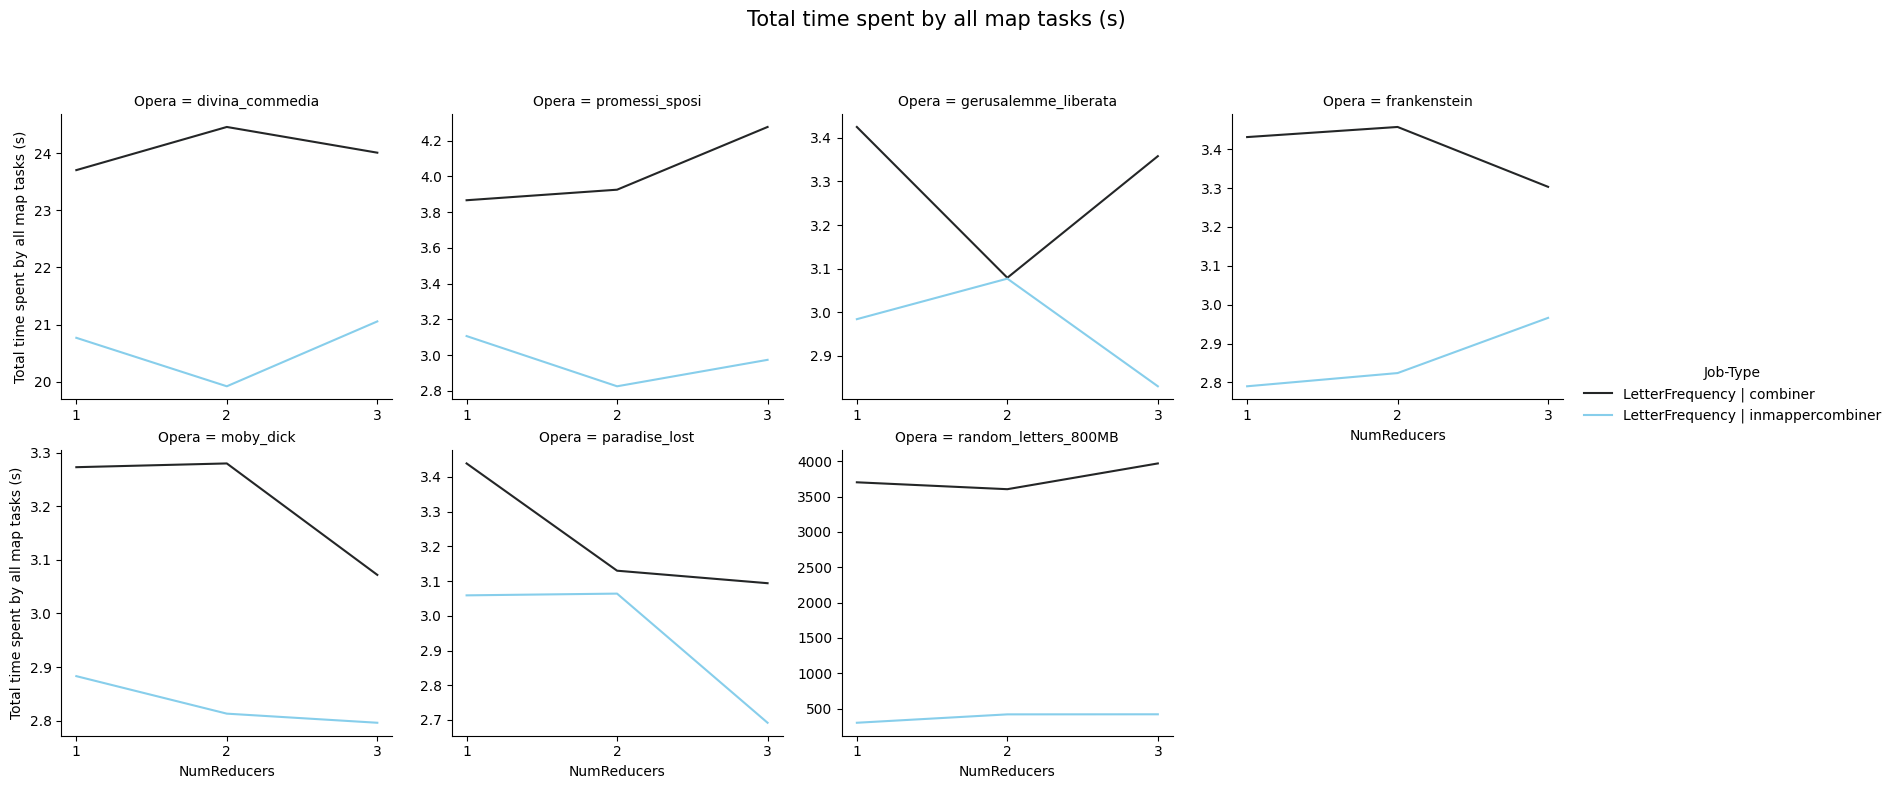

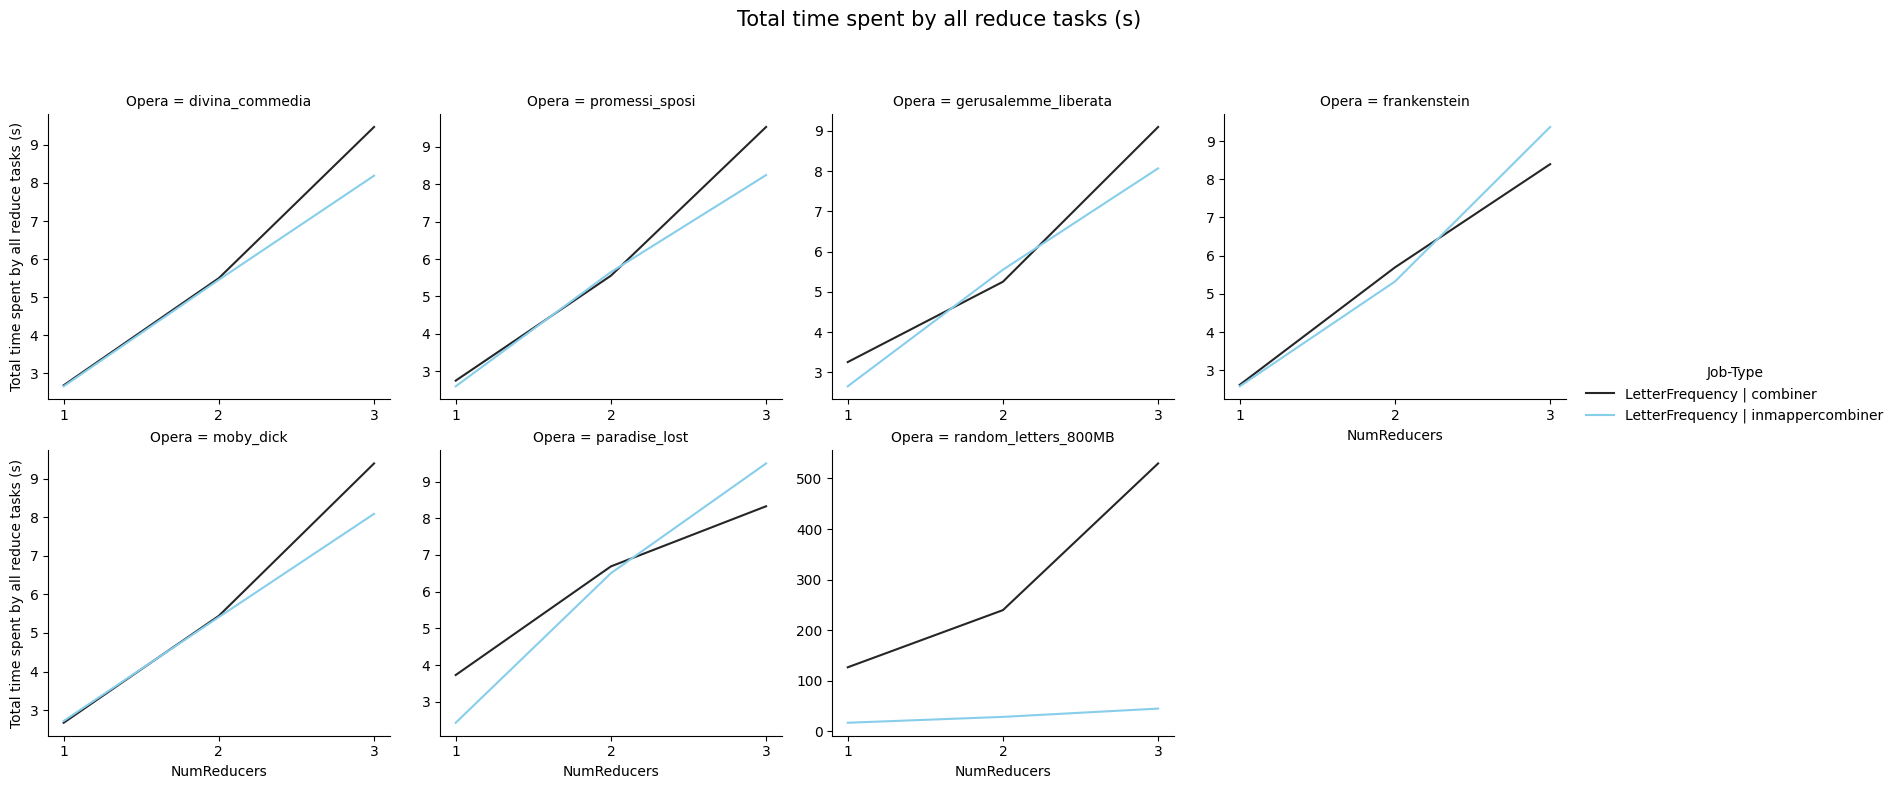

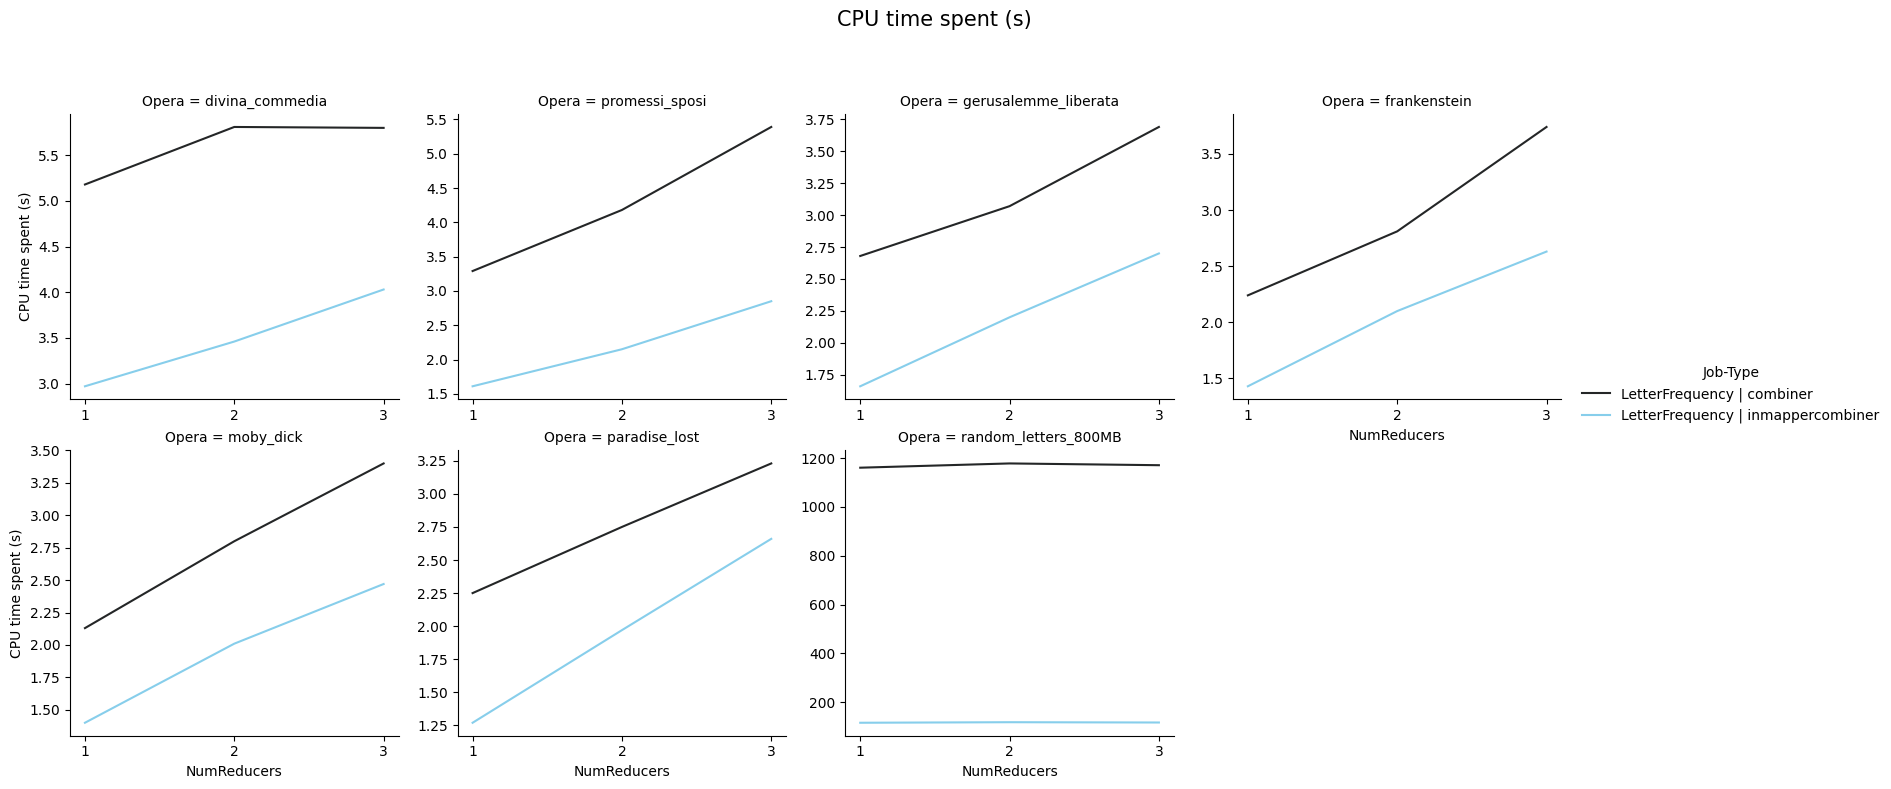

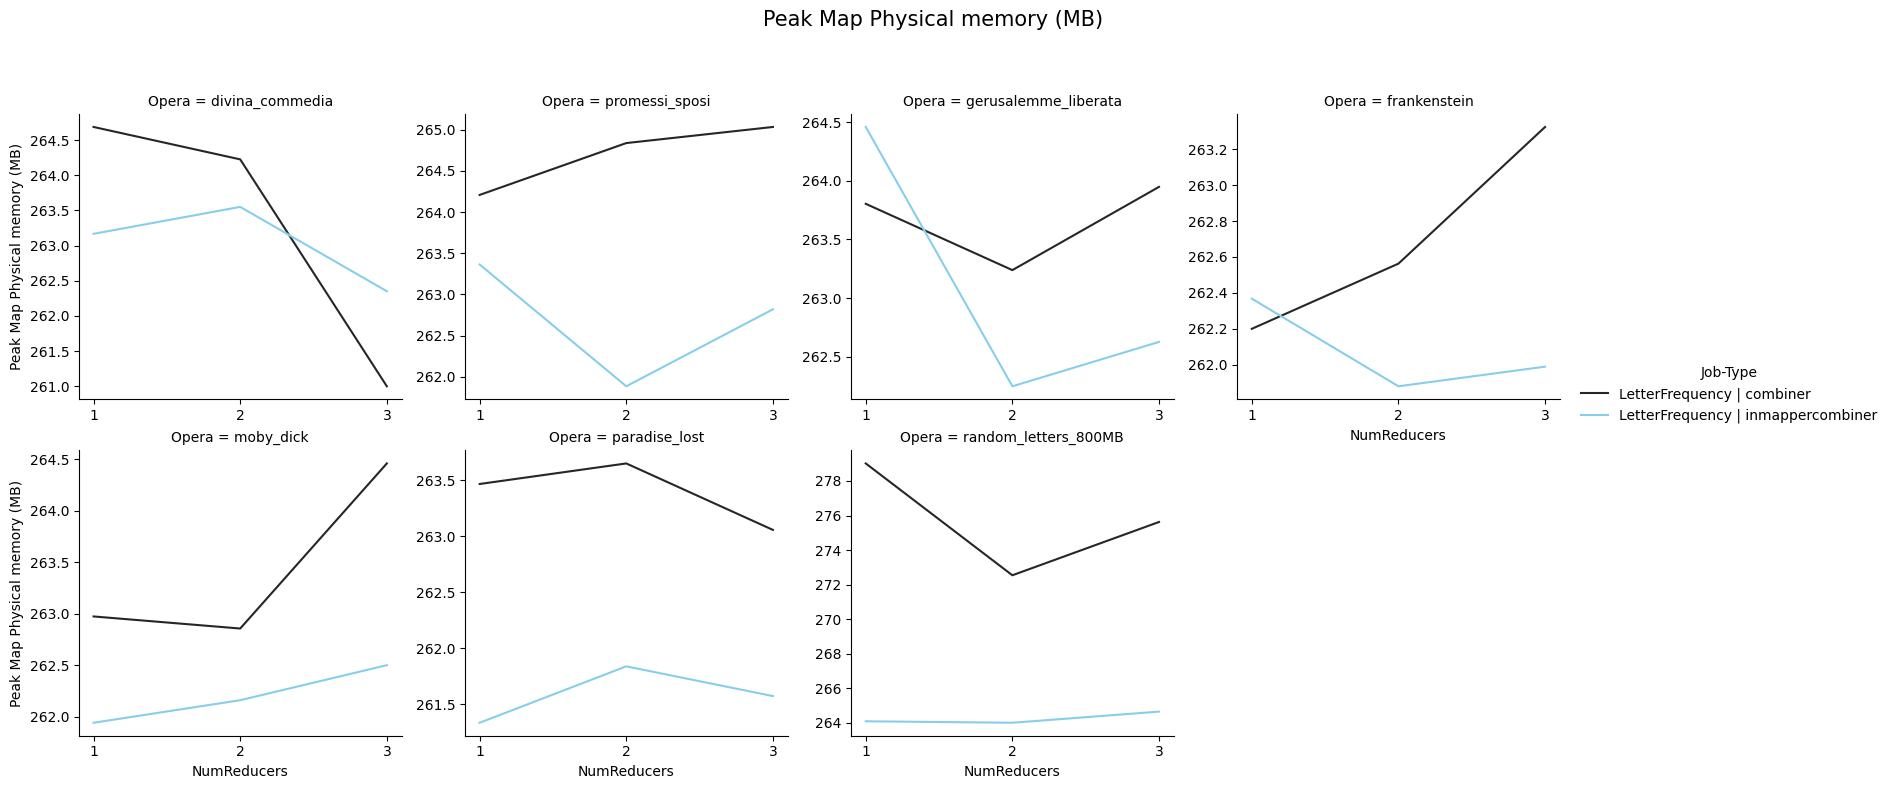

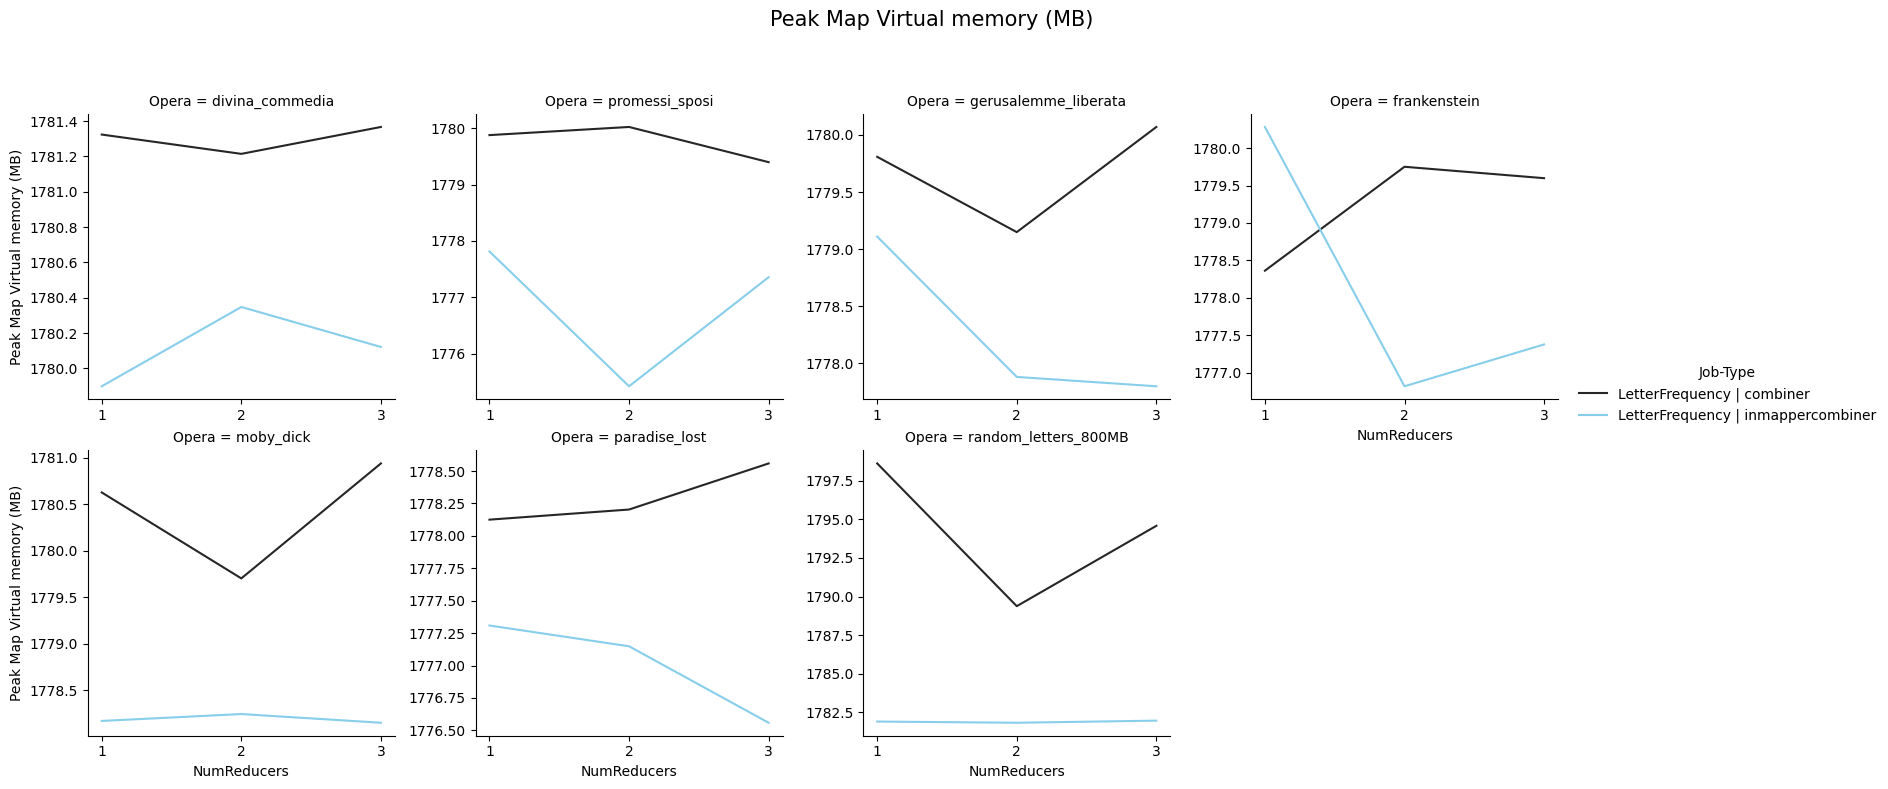

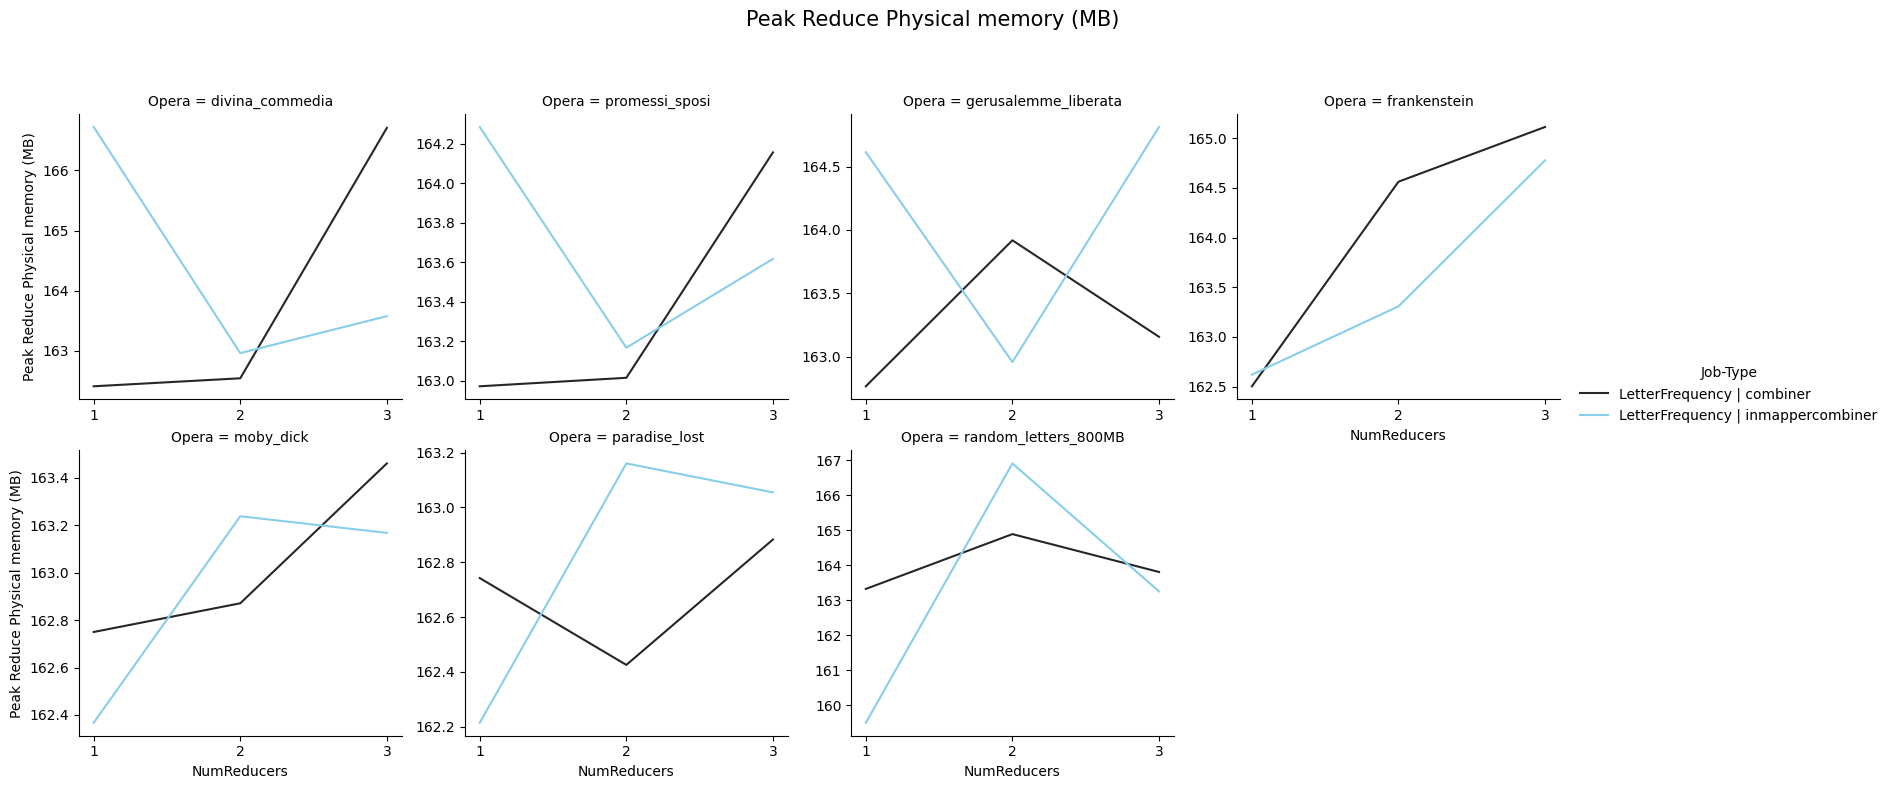

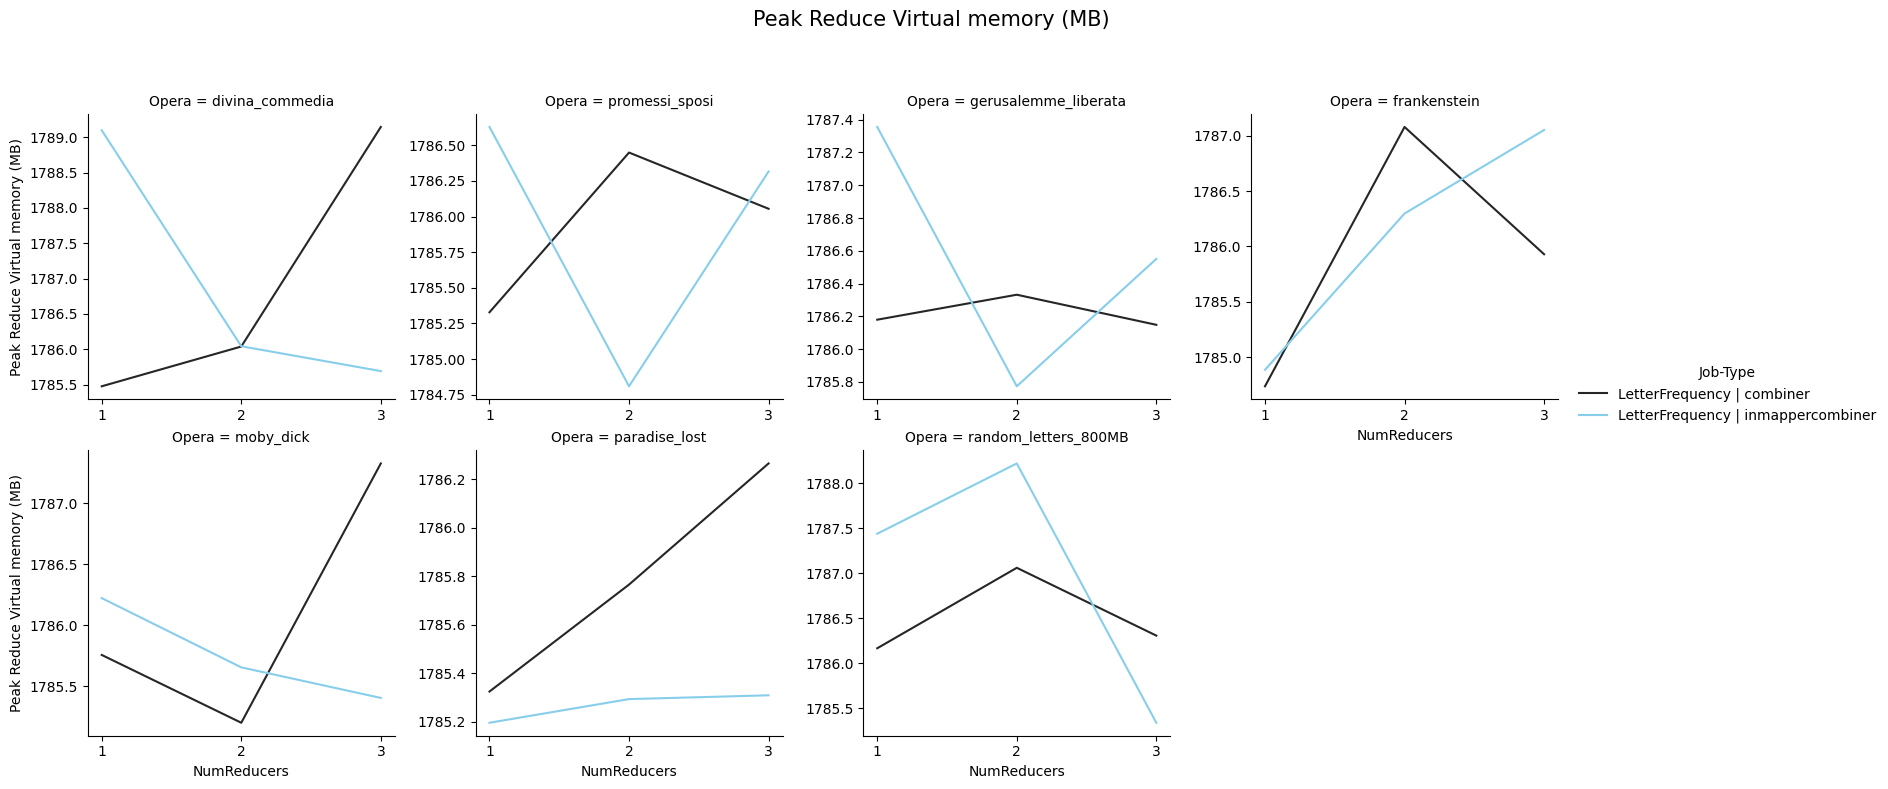

In [76]:
# Get unique integer values of 'NumReducers'
unique_values = df_freq['NumReducers'].unique()

# Plot each parameter in a separate subplot
for col in cols:
    g = sns.relplot(data=df_freq, 
                    x='NumReducers', 
                    y=col, 
                    hue='Job-Type', 
                    col='Opera', 
                    kind='line', 
                    col_wrap=4,
                    facet_kws={'sharey': False, 'sharex': False},
                    palette='dark:skyblue',
                    height=4,  # Adjust the height of each subplot as needed
                    aspect=1)  # Adjust the aspect ratio if necessary
    
    # Set integer ticks on x-axis
    g.set(xticks=unique_values)
    
    plt.subplots_adjust(top=0.85)  # Adjust top margin to make space for title
    plt.suptitle(f'{col}', fontsize=15)  # Set the title of the plot
    plt.show()
    
    
    


In [77]:
df_count = df[df['Job-Type'].isin(['LetterCount | combiner', 'LetterCount | inmappercombiner'])]

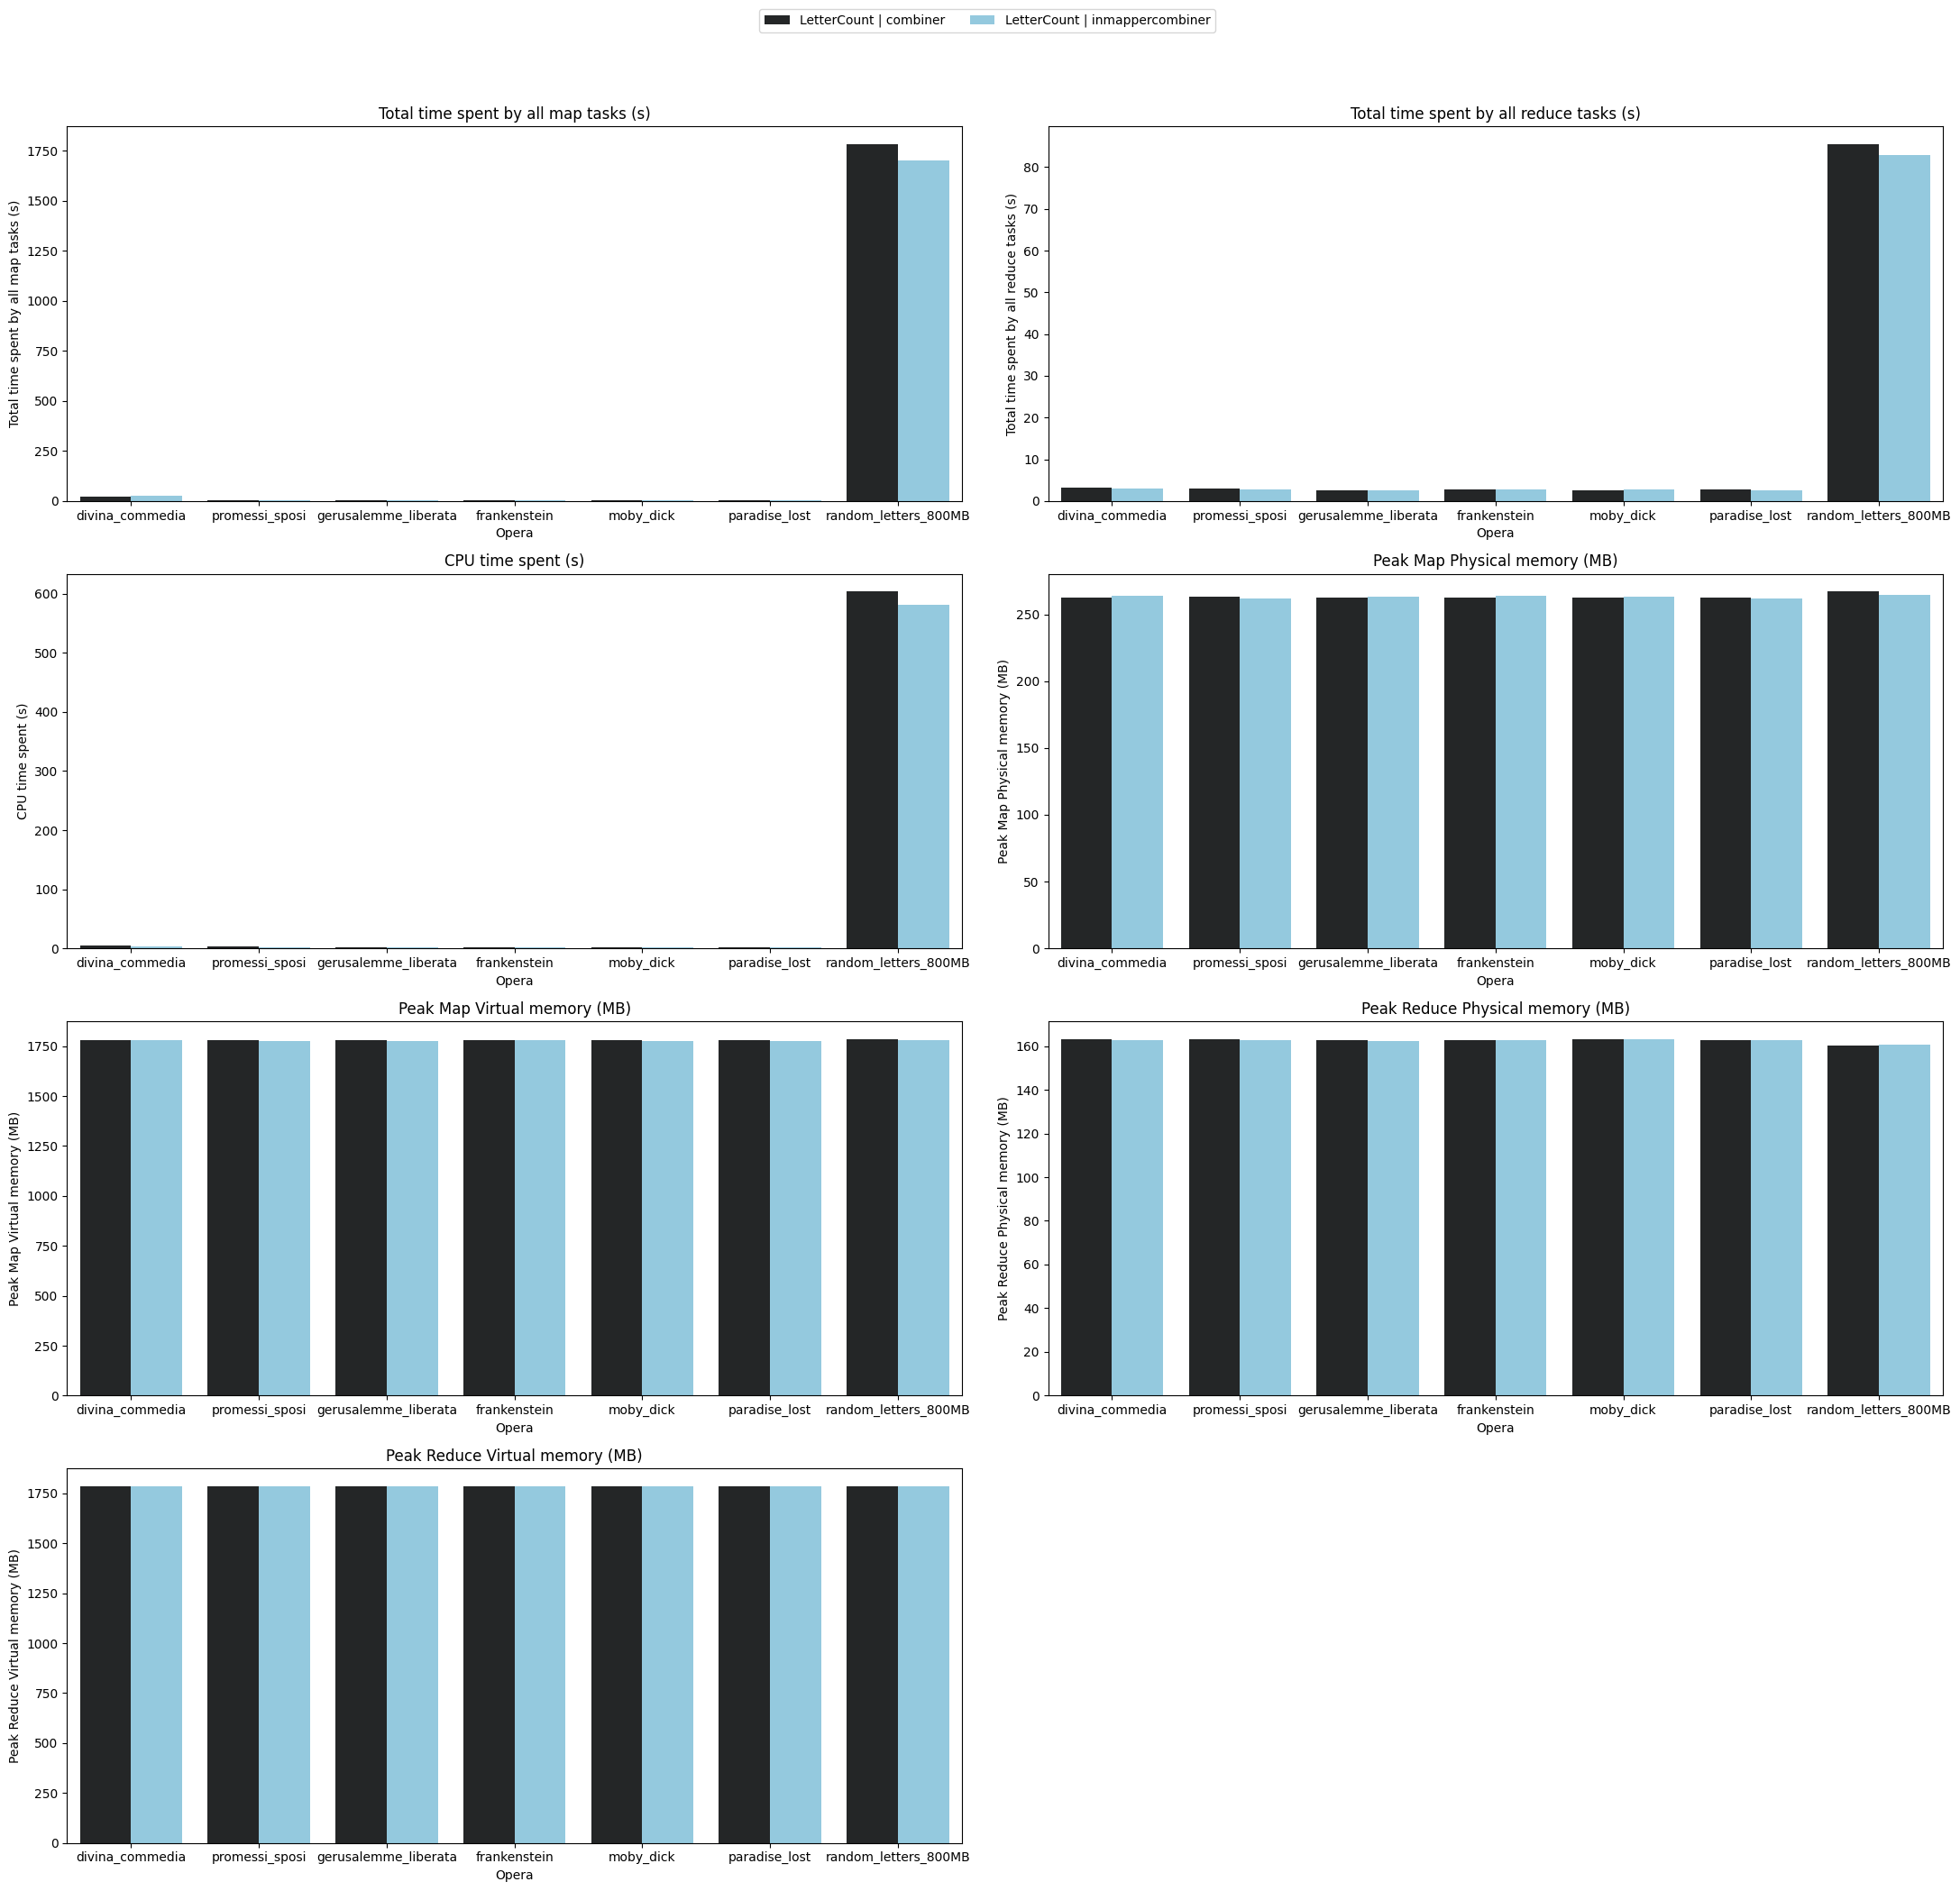

In [78]:
# Creazione del layout di subplot 4x2
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(22, 20))

# Ciclo per creare i bar plot in ciascun subplot
for i, col in enumerate(cols):
    row, col_pos = divmod(i, 2)  # Utilizza 2 invece di 3 per il layout 4x2
    sns.barplot(data=df_count, x='Opera', y=col, hue='Job-Type', ax=axes[row, col_pos], palette='dark:skyblue', ci=None)
    axes[row, col_pos].set_title(col)
    axes[row, col_pos].legend_.remove()  # Rimuovi la legenda da ogni singolo subplot

# Creare una singola legenda fuori dalla figura
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)

# Nascondere i subplot non utilizzati
total_plots = 4 * 2
for j in range(len(cols), total_plots):
    row, col_pos = divmod(j, 2)
    fig.delaxes(axes[row, col_pos])

# Regolazione automatica del layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il plot
plt.show()